In [3]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from minisom import MiniSom
import sys
import platform
from scipy.spatial import KDTree
from sympy import flatten


from lib.utils import *
from lib.plot_utils import *
from lib.event_processing import *

#Dynamicaly reload modules in juptyer notebook
%load_ext autoreload 
%autoreload 2

        recno  TYC1  TYC2  TYC3  BTmag  VTmag       HIP    RA(ICRS)  DE(ICRS)
0        9734    58  1618     1  4.687  2.716   14135.0   45.569912  4.089921
1        9659    58   607     1  5.487  5.591   14143.0   45.593785  4.352873
2       10433    62  1579     1  6.849  5.680   14915.0   48.109873  6.660885
3      134397   641   985     1  4.567  4.681   13954.0   44.928738  8.907399
4      135691   650  1471     1  4.721  3.705   15900.0   51.203480  9.029056
...       ...   ...   ...   ...    ...    ...       ...         ...       ...
4561  1314384  5204  1584     1  6.707  5.797  103981.0  316.019636 -5.823050
4562  1314058  5202  1366     1  7.014  5.951  105412.0  320.268022 -4.560152
4563  1314057  5202  1365     1  5.648  5.791  105164.0  319.546110 -4.519507
4564  1311170  5186  2126     1  5.440  5.539  103005.0  313.036222 -5.507044
4565  1311169  5186  2125     1  6.561  4.638  102624.0  311.934324 -5.027601

[4566 rows x 9 columns]
Data shape:  (4566, 3)
Star ID (HIP):  

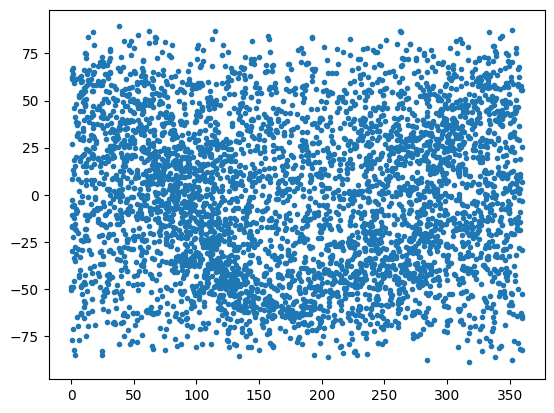

In [4]:

## Select the dataset type: 'random' or 'tycho'
# stars_data = utils.get_star_dataset(type ='random', n_stars = 4000)
catalog_path = '../data/catalogs/tycho2_VT_6.csv'
stars_data = get_star_dataset(type ='tycho', path = catalog_path)

print(stars_data)

# If data type is a dataframe from a catalog transform it to array
if isinstance(stars_data, pd.DataFrame):
    # stars_data['data_number'] = stars_data.index
    stars_data = stars_data[['HIP','RA(ICRS)', 'DE(ICRS)']].values

print("Data shape: ", stars_data.shape)

for i in range(5):
    print("Star ID (HIP): ", stars_data[i][0], ", lat:", stars_data[i][1], ", len: ", stars_data[i][2])

plt.figure()
plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')
plt.show()

In [5]:

# Create the k-d tree to find the nearest neighborhoods of the center stars
# As this is used only for the training of the SOM performace is not needed
tree = KDTree(stars_data[:,1:3])

n_of_neighbor = 4 # Number of neighborhoods stars used to compute the features

# Find the 5 closest neighbors for each star
distances, indices = tree.query(stars_data[:,1:3], k=n_of_neighbor+1)

#Initialice the dual SOM features vector
features_vec_1 = []
features_vec_2 = []


# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):
    print("Star ID:", stars_data[i][0], "(","%0.6f" % stars_data[i][1],",","%0.6f" %stars_data[i][2],")")

    # Initialice the subsets of features
    features_1 = []
    features_2 = []
    # features_3 = []

    for j in range(1,n_of_neighbor+1):
        neighbor_index = indices[i][j]
        print("Neighbor ID:", stars_data[neighbor_index][0], "(","%0.6f" %stars_data[neighbor_index][1],",","%0.6f" %stars_data[neighbor_index][2],")")


    features_1, features_2 = get_star_features(stars_data[indices[i][0:n_of_neighbor+1]][:,1:3], 1, 1, 1)
    features_vec_1.append(features_1)
    features_vec_2.append(features_2)
    # features_vec_3.append(features_3)
    print('features_1: ', features_1)
    print('features_2: ', features_2)

    print("Number of features: ", len(features_vec_1[0]),",",len(features_vec_2[0]) )
    print('----------------------')

features_vec_1 = np.array(features_vec_1)
features_vec_2 = np.array(features_vec_2)

# Normalize the data -> better performace of the SOM 
def normalize_features(star_features):
    star_features_normalized = (star_features - star_features.min()) / (star_features.max() - star_features.min())
    return star_features_normalized

features_1_n = normalize_features(np.array(features_vec_1))
features_2_n = normalize_features(np.array(features_vec_2))

Star ID: 14135.0 ( 45.569912 , 4.089921 )
Neighbor ID: 14143.0 ( 45.593785 , 4.352873 )
Neighbor ID: 14915.0 ( 48.109873 , 6.660885 )
Neighbor ID: 15457.0 ( 49.839787 , 3.369980 )
Neighbor ID: 15619.0 ( 50.278217 , 3.675680 )
features_1:  [-1.33168062  0.          1.28482521  5.59439346  1.46560083  4.63589112
  1.55318345  4.71517452]
features_2:  [0.26403315 3.61403621 4.33014412 4.7264928  3.41432565 4.35828078
 4.73312743 3.71788338 3.68960193 0.53448458]
Number of features:  8 , 10
----------------------
Star ID: 14143.0 ( 45.593785 , 4.352873 )
Neighbor ID: 14135.0 ( 45.569912 , 4.089921 )
Neighbor ID: 14915.0 ( 48.109873 , 6.660885 )
Neighbor ID: 15457.0 ( 49.839787 , 3.369980 )
Neighbor ID: 13954.0 ( 44.928738 , 8.907399 )
features_1:  [-1.33168062  0.          1.22798001  2.40362904  1.47207766  1.43385689
  1.52667005  3.37712728]
features_2:  [0.26403315 3.41432565 4.35828078 4.6028241  3.61403621 4.33014412
 4.85995782 3.71788338 3.89441158 7.40144585]
Number of features:  

Star ID: 12828.0 ( 41.234935 , 10.114216 )
Neighbor ID: 12832.0 ( 41.239628 , 12.445956 )
Neighbor ID: 12153.0 ( 39.157316 , 12.447840 )
Neighbor ID: 12148.0 ( 39.146259 , 7.730073 )
Neighbor ID: 13954.0 ( 44.928738 , 8.907399 )
features_1:  [0.84661668 0.         1.13926392 0.72944132 1.15362243 2.42417003
 1.35736703 4.39862038]
features_2:  [2.33174444 3.12446767 3.16965397 3.88594822 2.0823128  5.15962682
 5.11184133 4.71778018 6.77082253 5.90111532]
----------------------


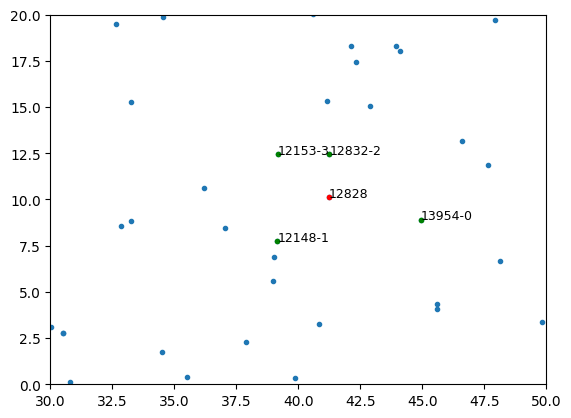

In [6]:
# Search the neighbors of a specific star

stars_sublist = [12828]

# Compute the distances in the x and y axes to each of the five closest stars for each star
for i in range(len(stars_data)):

    if stars_data[i][0] in stars_sublist:
        print("Star ID:", stars_data[i][0], "(","%0.6f" % stars_data[i][1],",","%0.6f" %stars_data[i][2],")")

        neihgtbors_list = []
        for j in range(1,n_of_neighbor+1):
            neighbor_index = indices[i][j]
            print("Neighbor ID:", stars_data[neighbor_index][0], "(","%0.6f" %stars_data[neighbor_index][1],",","%0.6f" %stars_data[neighbor_index][2],")")
            neihgtbors_list.append(stars_data[neighbor_index][0])

        # features_vec_3.append(features_3)
        print('features_1: ', features_vec_1[i])
        print('features_2: ', features_vec_2[i])
        print('----------------------')

        plt.figure()
        plt.plot([x[1] for x in stars_data],stars_data[:,2],'.')

        plt.plot(stars_data[i,1],stars_data[i,2],'.r')
        plt.text(stars_data[i,1], stars_data[i,2], int(stars_data[i,0]), fontsize=9)

        stars_subdata = stars_data[np.where(np.isin(stars_data[:,0], neihgtbors_list))]
        plt.plot([x[1] for x in stars_subdata],stars_subdata[:,2],'.g')
        #Plot the identification names of the sub set of stars
        for i in range(len(stars_subdata)):
            plt.text(stars_subdata[i,1], stars_subdata[i,2], str(int(stars_subdata[i,0])) + '-' + str(i), fontsize=9)

        #change the limits of the axis
        plt.xlim([30, 50])
        plt.ylim([0, 20])

        plt.show()  

In [29]:

## SINGLE TRAINING ##

# Must be more neurons that points -> sqrt of data size to set the mesh: data < som_rows * som_cols
# mesh_size = int(np.sqrt(features_1_n.shape[0])/2)
# Manual set 

hyperparameters = {
    'mesh_size_1': 80,
    'mesh_size_2': 80,
    'sigma': 2.5596681755111366,
    'learning_rate': 0.8425001624399555,
    'neighborhood_function': 'triangle',
    'topology': 'rectangular',
    'activation_distance': 'euclidean',
}

# hyperparameters = {'mesh_size_1': 60, 'mesh_size_2': 60, 'sigma': 3.263122498850444, 'learning_rate': 0.7894422310231358, 'neighborhood_function': 'triangle', 'topology': 'rectangular', 'activation_distance': 'euclidean'}

# Initialize the SOM
som1 = MiniSom(
    x = hyperparameters['mesh_size_1'],
    y = hyperparameters['mesh_size_1'],
    input_len = features_1_n.shape[1],

    sigma=hyperparameters['sigma'],
    learning_rate=hyperparameters['learning_rate'],
    neighborhood_function=hyperparameters['neighborhood_function'],
    topology=hyperparameters['topology'],
    activation_distance=hyperparameters['activation_distance']

)

som2 = MiniSom(
    x = hyperparameters['mesh_size_2'],
    y = hyperparameters['mesh_size_2'],
    input_len = features_2_n.shape[1],

    sigma=hyperparameters['sigma'],
    learning_rate=hyperparameters['learning_rate'],
    neighborhood_function=hyperparameters['neighborhood_function'],
    topology=hyperparameters['topology'],
    activation_distance=hyperparameters['activation_distance']
)

print(f"SOM 1 size = {hyperparameters['mesh_size_1']} x {hyperparameters['mesh_size_1']} = {hyperparameters['mesh_size_1']**2}")
print(f"SOM 2 size = {hyperparameters['mesh_size_2']} x {hyperparameters['mesh_size_2']} = {hyperparameters['mesh_size_2']**2}")

# Train the SOM
som1.train_random(data=features_1_n, num_iteration=50000, verbose= True)
som2.train_random(data=features_2_n, num_iteration=50000, verbose= True)




SOM 1 size = 80 x 80 = 6400
SOM 2 size = 80 x 80 = 6400
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.02763190829764004
 [ 50000 / 50000 ] 100% - 0:00:00 left 
 quantization error: 0.024755163697933593


In [40]:
# Train more 
som1.train_random(data=features_1_n, num_iteration=1000000, verbose= True)
som2.train_random(data=features_2_n, num_iteration=1000000, verbose= True)


 [ 1000000 / 1000000 ] 100% - 0:00:00 left 
 quantization error: 0.001305676580914499
 [ 1000000 / 1000000 ] 100% - 0:00:00 left 
 quantization error: 0.001781951354040587


In [9]:
# Check that neurons correspond to a star, the rest of the neurons don't have any star ID set,
#  this also imply that there are some neurons with more than one star parameters stored 

# Another dict for map neurons to star (just to check), same as star_ids but created from som.winner rather than som.winner_map
def add_values_in_dict(sample_dict, key, list_of_values):
    ''' Append multiple values to a key in 
        the given dictionary '''
    if key not in sample_dict:
        sample_dict[key] = list()
    sample_dict[key].extend(list_of_values)
    return sample_dict

star_dict_1= {}
star_dict_2= {}

for i in range(len(features_1_n)):
    star_dict_1 = add_values_in_dict(star_dict_1, som1.winner(features_1_n[i]),[i])
    star_dict_2 = add_values_in_dict(star_dict_2, som2.winner(features_2_n[i]),[i])


print("Number of neurons with data:",len(star_dict_1),"; Total neurons:", som1._xx.shape[0]*som1._xx.shape[1])
print("Number of neurons with data:",len(star_dict_2),"; Total neurons:", som2._xx.shape[0]*som2._xx.shape[1])
star_dict_2

Number of neurons with data: 4351 ; Total neurons: 6400
Number of neurons with data: 4166 ; Total neurons: 6400


{(6, 20): [0],
 (43, 60): [1],
 (57, 61): [2],
 (72, 79): [3],
 (65, 17): [4],
 (13, 20): [5],
 (13, 55): [6],
 (52, 75): [7],
 (10, 64): [8],
 (11, 31): [9],
 (52, 50): [10],
 (52, 52): [11],
 (20, 5): [12, 4491],
 (66, 55): [13],
 (69, 37): [14],
 (56, 53): [15],
 (3, 9): [16],
 (25, 58): [17],
 (18, 38): [18],
 (17, 40): [19],
 (25, 16): [20],
 (25, 15): [21],
 (78, 66): [22],
 (44, 14): [23],
 (21, 73): [24],
 (52, 31): [25],
 (64, 59): [26],
 (27, 25): [27, 4166],
 (32, 26): [28, 3604],
 (32, 30): [29],
 (33, 26): [30],
 (7, 22): [31],
 (19, 14): [32],
 (20, 14): [33],
 (61, 41): [34],
 (66, 19): [35],
 (31, 14): [36],
 (61, 19): [37],
 (60, 19): [38],
 (29, 30): [39, 2138],
 (26, 29): [40, 1879, 3282, 3283],
 (28, 30): [41, 50],
 (27, 30): [42, 43, 44],
 (13, 28): [45, 3661],
 (43, 33): [46],
 (25, 31): [47],
 (29, 29): [48],
 (25, 30): [49],
 (28, 26): [51],
 (27, 47): [52],
 (27, 29): [53, 1883],
 (32, 59): [54],
 (30, 17): [55],
 (24, 16): [56],
 (62, 44): [57],
 (11, 20): [58

In [7]:
import pickle

mesh_size = hyperparameters['mesh_size_1']

name = 'n'+ str(mesh_size) +'_tycho' + catalog_path[-5:-4]

print(name)

# Create a directory to save the SOM parameters
if not os.path.exists('../data/SOM_parameters/'+ name):
    os.makedirs('../data/SOM_parameters/'+ name)

# saving the som in the file som.p
with open('../data/SOM_parameters/'+name+'/som1_'+ name + '.p', 'wb') as outfile:
    pickle.dump([som1, som2], outfile)

# Save normalization parameters
with open('../data/SOM_parameters/'+name+'/normalization_parameters_tycho' + catalog_path[-5:-4] + '.p', 'wb') as outfile:
    pickle.dump([features_vec_1.min(), features_vec_1.max(), features_vec_2.min(), features_vec_2.max()], outfile)

# Save dictionario of neurons to star
with open('../data/SOM_parameters/'+name+'/star_dict_'+ name + '.p', 'wb') as outfile:
    pickle.dump([star_dict_1, star_dict_2], outfile)

with open('../data/SOM_parameters/'+name+'/index_'+ name + '.p', 'wb') as outfile:
    pickle.dump(indices, outfile)


NameError: name 'hyperparameters' is not defined

In [48]:
## For optuna training 
# with open('../training_optuna/features/norm_features_'+ 'tycho' + catalog_path[-5:-4] + '.p', 'wb') as outfile:
#     pickle.dump([features_1_n,features_1_n], outfile)


In [8]:
mesh_size = 80
catalog_filter = 6

name = 'n'+ str(mesh_size) +'_tycho' + str(catalog_filter)


#Load som from previusly trained model
with open('../data/SOM_parameters/'+name+'/som1_'+ name + '.p', 'rb') as infile:
    som1, som2 = pickle.load(infile)

#Load normalization parameters
with open('../data/SOM_parameters/'+name+'/normalization_parameters_tycho' + str(catalog_filter) + '.p', 'rb') as infile:
    norm_param = pickle.load(infile)

#Load dictionary with the star features
with open('../data/SOM_parameters/'+name+'/star_dict_'+ name + '.p', 'rb') as infile:
    star_dict_1, star_dict_2 = pickle.load(infile)

In [37]:
from lib.event_processing import predict_star_id
# Test the prediction for a sample feature vector
random_id = np.random.randint(0,len(features_vec_1))
# random_id = np.where(stars_data[:,0] == 12828)[0][0] # To check the prediction of a specific star (not that random)

sample_feature_1= features_vec_1[random_id] 
sample_feature_2= features_vec_2[random_id] 

predicted_star_ids_1 = predict_star_id(sample_feature_1, [features_vec_1.min(), features_vec_1.max()], star_dict_1, som1)
predicted_star_ids_2 = predict_star_id(sample_feature_2, [features_vec_2.min(), features_vec_2.max()], star_dict_2, som2)

if len(list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))) < 2:
    star_guess = list(set(predicted_star_ids_1).intersection(predicted_star_ids_2))[0]
else:
    star_guess = None

print(f"SOM1: Predicted Stars ID: {predicted_star_ids_1}")
print(f"SOM2: Predicted Stars ID: {predicted_star_ids_2}" )
print(f"Final guess: {star_guess}, actual star ID: {random_id}")

plt.figure()
plt.plot(stars_data[:,1],stars_data[:,2],'.')
plt.plot(stars_data[random_id][1],stars_data[random_id][2],'og')
plt.plot(stars_data[star_guess][1],stars_data[star_guess][2],'xr')
plt.show()


TypeError: unhashable type: 'list'

In [44]:


x = predict_star_id(features_1, [features_vec_1.min(), features_vec_1.max()], star_dict_1, som1, two_best_bmu=True)

print(flatten   (x))

[4565, 0]


In [55]:
import time 

cont = np.zeros(5) # [Correct match, miss match, multiple match, correct SOM1, correct SOM2]

stars_pos = np.copy(stars_data[:,1:3])

noise= np.random.normal(loc=1, scale=0.001, size=stars_pos.shape)
mean_noise = np.mean(np.abs(1-noise), axis=0)

stars_pos *= noise

time_start = time.time()
for i in range(len(stars_pos)):

    features_1 = []
    features_2 = []

    features_1, features_2 = get_star_features(stars_pos[indices[i][0:n_of_neighbor+1]], 1, 1, 1)

    winner_ids_1, second_ids_1 = predict_star_id(features_1, [features_vec_1.min(), features_vec_1.max()], star_dict_1, som1, True)
    winner_ids_2, second_ids_2 = predict_star_id(features_2, [features_vec_2.min(), features_vec_2.max()], star_dict_2, som2, True)
    if i in winner_ids_1:
        cont[3] += 1
    if i in winner_ids_2:
        cont[4] += 1
    
    star_guess = list(set(winner_ids_1).intersection(winner_ids_2))
    if len(star_guess) == 1 and star_guess !=0:
        cont[0] += star_guess[0] == i
        cont[1] += star_guess[0] != i
    else:
        if len(star_guess) == 0:
            star_guess = list(set(flatten([winner_ids_1, second_ids_1])).intersection(flatten([winner_ids_2, second_ids_2])))
            if len(star_guess) == 1 and star_guess !=0:
                cont[0] += star_guess[0] == i
                cont[1] += star_guess[0] != i
            else:
                cont[1] += len(star_guess) == 0
                cont[2] += len(star_guess) > 1
time_end = time.time()

print('number of cases:', np.sum(cont[0:3]))
print("mean noise level=",  mean_noise, 'noise example: ', noise[0]*stars_pos[0]-stars_pos[0])
print("total success =",  cont[0:3] / stars_pos.shape[0],)
print( ' SOM1 success:', cont[3] / stars_pos.shape[0], ' SOM2 success:', cont[4] / stars_pos.shape[0])
print("total time=",  time_end - time_start)
print("total time per star=",  (time_end - time_start) / stars_pos.shape[0])


number of cases: 4544.0
mean noise level= [0.00077801 0.00079018] noise example:  [ 0.0077346  -0.00511194]
total success = [0.78449409 0.19491897 0.01576873]
 SOM1 success: 0.7921594393342094  SOM2 success: 0.9027595269382391
total time= 10.51662564277649
total time per star= 0.002303246965128447
